# Digit Emoji Predictor: Build UI for Deep Learning model in Jupyter Notebook

Build a digit emoji predictor in Jupyter notebook by passing data between JavaScript & Python. Typically, JavaScripts are used for data visualization in notebooks, but it can also be used for prototyping front-end/UI for deep learning models.

# Why the hell build UI in notebook?

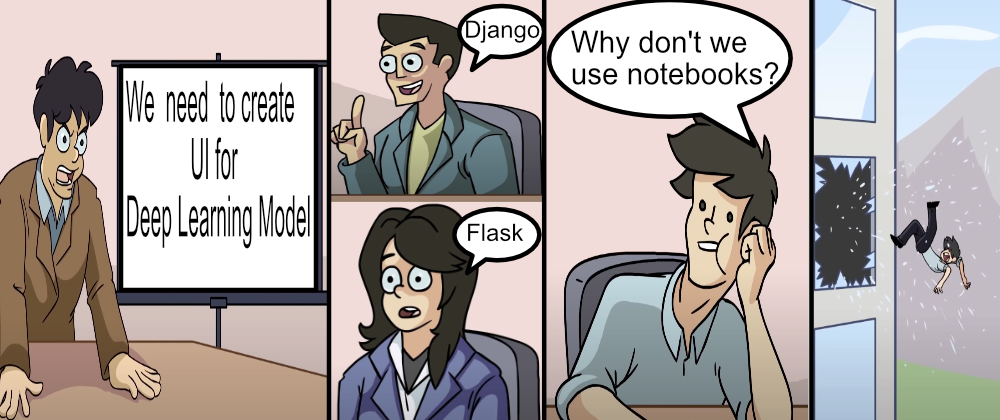

Short Answer: 
> *Share the Deep Learning model notebook with colleagues from different teams like Business, Data Science, Front End developer, DevOps for their opinion before the real software development takes place.*

<p>Jupyter notebook is meant for quick prototyping and everyone knows this but what many misses is we can also do a quick prototype of UI as well. Many data scientists are <b>quick to start</b> building the big deep learning model with whatever little data they have without even thinking about what they are developing and for whom &#129335;&#8205;&#9794;&#65039;. Trust me, the first model you are satisfied with (based on the metrics like accuracy) won't be deployed into production for various reasons like slow inference time, no on-device support, memory hogging blah blah. 

Even experienced project/product managers sometimes won't know what they really want so first try to get the workflow or pipeline agreement from all the players involved, even with this some things will slip through the crack.  "<u>I am data scientist, My job is only to build ML models is not the right mindset, at least in my opinion.</u>" A tad bit of knowledge in  Business, Web development, DevOps can help you save a ton of time in trying to debug, or explain why the model/workflow you built is the best for business. Better to be jack of all trades here. BTW, this does not mean that you should take over the responsibilities of your colleagues. Just try to get a sense of what is happening outside your circle. In this post, Let me share an example of how creating a simple UI for input & output for deep learning model can help you see the cracks in your workflow and increase productivity.</p>

# Application

If you are not familiar with [MNIST](https://www.kaggle.com/c/digit-recognizer) dataset  then just know that you can build a **Digit Emoji Predictor** as the dataset contains gray-scale images of hand-drawn digits, from zero through nine. So our UI is going to let the user draw a digit & display the corresponding emoji.

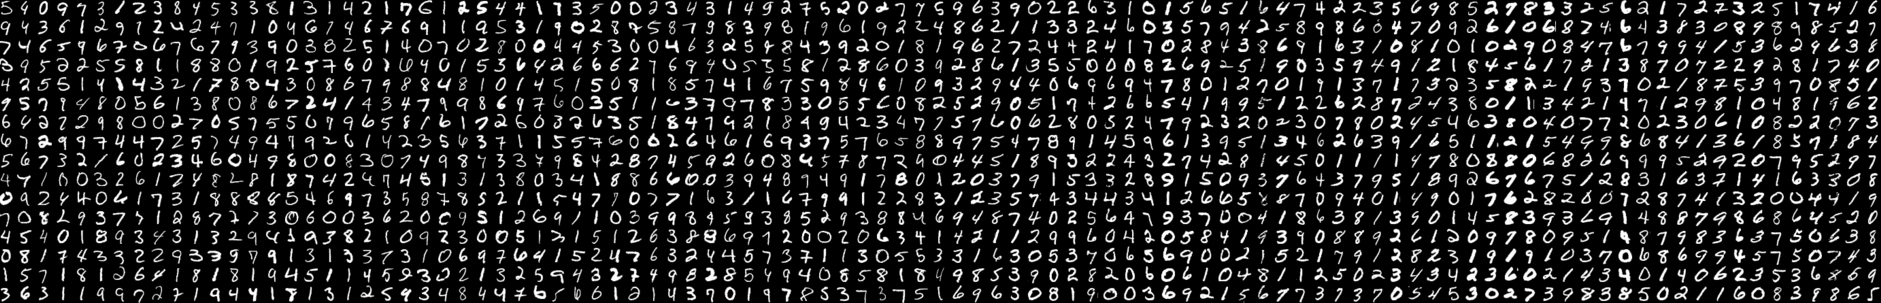

# Okay, I am somewhat convinced to build UI but now what?

Firstly, we will decide what we are going to build? Instead of creating from scratch let us try to recreate [Digit Recognizer](https://towardsdatascience.com/deploying-your-first-deep-learning-model-mnist-in-production-environment-510bfdc4808d) in notebook without using Django. The use case we have chosen is great because we can't simply use `pywidgets`, this forces us to dig deep into the world of HTML & Javascript. In the longer run this route has more benefits because of unlimited capability, free resource and more importantly closer to the actual front-end. Ofcourse if all you want is a slider then just roll with `pywidgets`. We will first setup the back-end and then get back to the UI.

![Digit Recognizer](https://miro.medium.com/max/600/1*O7dIAVNyGA-J4U3fcQLZNg.gif)

# Digit Emoji Recognizer

I have trained the CNN Deep learning model using the `pytorch`, we will just download the model & weights from [here](https://github.com/6aravind/tidbits/blob/main/assets/models/mnist_model.pth). This is a simple model with 3 *Conv blocks* and 2 *Fully connected layer*. The Transformations used for this model are `Resize` & `ToTensor`. Upon calling the `predict` function on the image, we will get the predicted digit.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# Digit Recognizer model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
 


# Predict the digit given the tensor
def predict(image, modelName = 'mnist_model.pth'):
    
    # Resize before converting the image to Tensor
    Trfms = transforms.Compose([transforms.Resize(28), transforms.ToTensor()])
    
    # Apply transformations and increase dim for mini-batch dimension
    imageTensor = Trfms(image).unsqueeze(0)
    
    # Download model from URL and load it
    model = torch.load(modelName)
    
    # Activate Eval mode
    model.eval()
    
    # Pass the image tensor by the model & return max index of output
    with torch.no_grad():
        out = model(imageTensor)
        return int(torch.max(out, 1)[1])

We need a helper function to convert **BASE64 Image** (canvas area in which the user is going to draw the digit) to **PIL Image**.

In [2]:
import re, base64
from PIL import Image
from io import BytesIO

# Decode the image drawn by the user
def decodeImage(codec):
    
    # remove the front part of codec
    base64_data = re.sub('^data:image/.+;base64,', '', codec)
    
    # base64 decode
    byte_data = base64.b64decode(base64_data)
    
    # Convert to bytes
    image_data = BytesIO(byte_data)
    
    # Convert to image & convert to grayscale
    img = Image.open(image_data).convert('L')
    return img

Now let us combine the two functions namely `decodeImage` and `predict` as a separate function. This way is easier because the output of the function (emoji html code) can be directly passed to the HTML tag via JavaScript. Hang on for a bit if you are confused, things will get much easier to follow in the next section.

In [6]:
# Decode the image and predict the value
def decode_predict(imgStr):
    
    # Decode the image
    image = decodeImage(imgStr)
    
    # Declare html codes for 0-9 emoji
    emojis = [ 
            "&#48;&#65039;&#8419;",
             "&#49;&#65039;&#8419;",
             "&#50;&#65039;&#8419;",
             "&#51;&#65039;&#8419;",
             "&#52;&#65039;&#8419;",
             "&#53;&#65039;&#8419;",
             "&#54;&#65039;&#8419;",
             "&#55;&#65039;&#8419;",
             "&#56;&#65039;&#8419;",
             "&#57;&#65039;&#8419;"
    ]
    
    # Call the predict function
    digit = predict(image)
    
    # get corresponding emoji
    return emojis[digit]

# UI

<p>The HTML & CSS part are quite straight forward, the JavaScript lets the user to draw inside the canvas and call functions via the buttons <code>Predict</code> & <code>Clear</code>. The <code>Clear</code> button cleans up the canvas and sets the result to &#129300; emoji. We will setup the <code>Predict</code> button JS function in the next section.</p>

In [3]:
from IPython.display import HTML

html = """
<div class="outer">
        <! -- HEADER SECTION -->
    <div> 
        <h3 style="margin-left: 30px;"> Digit Emoji Predictor &#128640; </h3> 
        <br>
        <h7 style="margin-left: 40px;"> Draw a digit from &#48;&#65039;&#8419; - &#57;&#65039;&#8419;</h7>
    </div>
    
    <div>
           <! -- CANVAS TO DRAW THE DIGIT -->
        <canvas id="canvas" width="250" height="250" style="border:2px solid; float: left; border-radius: 5px; cursor: crosshair;">
        </canvas>

            <! -- SHOW PREDICTED DIGIT EMOJI-->
        <div class="wrapper1"> <p id="result">&#129300;</p></div>
        
            <! -- BUTTONS TO CALL DL MODEL & CLEAR THE CANVAS -->
        <div class="wrapper2">
            <button type="button" id="predictButton" style="color: #4CAF50;margin:10px;">  Predict </button>  
            <button type="button" id="clearButton" style="color: #f44336;margin:10px;">  Clear </button>  
        </div>
    </div>
</div>
"""


css = """
<style>
    .wrapper1 {
      text-align: center;
      display: inline-block;
      position: absolute;
      top: 82%;
      left: 25%;
      justify-content: center;
      font-size: 30px;
    }
    .wrapper2 {
      text-align: center;
      display: inline-block;
      position: absolute;
      top: 90%;
      left: 19%;
      justify-content: center;
    }
    
    .outer {
        height: 400px; 
        width: 400px;
        justify-content: center;
    }

</style>
"""


javascript = """

<script type="text/javascript">
(function() {
    /* SETUP CANVAS & ALLOW USER TO DRAW */
	var canvas = document.querySelector("#canvas");
	canvas.width = 250;
	canvas.height = 250;
	var context = canvas.getContext("2d");
	var canvastop = canvas.offsetTop
	var lastx;
	var lasty;
	context.strokeStyle = "#000000";
	context.lineCap = 'round';
	context.lineJoin = 'round';
	context.lineWidth = 5;

	function dot(x, y) {
		context.beginPath();
		context.fillStyle = "#000000";
		context.arc(x, y, 1, 0, Math.PI * 2, true);
		context.fill();
		context.stroke();
		context.closePath();
	}

	function line(fromx, fromy, tox, toy) {
		context.beginPath();
		context.moveTo(fromx, fromy);
		context.lineTo(tox, toy);
		context.stroke();
		context.closePath();
	}
	canvas.ontouchstart = function(event) {
		event.preventDefault();
		lastx = event.touches[0].clientX;
		lasty = event.touches[0].clientY - canvastop;
		dot(lastx, lasty);
	}
	canvas.ontouchmove = function(event) {
		event.preventDefault();
		var newx = event.touches[0].clientX;
		var newy = event.touches[0].clientY - canvastop;
		line(lastx, lasty, newx, newy);
		lastx = newx;
		lasty = newy;
	}
	var Mouse = {
		x: 0,
		y: 0
	};
	var lastMouse = {
		x: 0,
		y: 0
	};
	context.fillStyle = "white";
	context.fillRect(0, 0, canvas.width, canvas.height);
	context.color = "black";
	context.lineWidth = 10;
	context.lineJoin = context.lineCap = 'round';
	debug();
	canvas.addEventListener("mousemove", function(e) {
		lastMouse.x = Mouse.x;
		lastMouse.y = Mouse.y;
		Mouse.x = e.pageX - canvas.getBoundingClientRect().left;
		Mouse.y = e.pageY - canvas.getBoundingClientRect().top;
	}, false);
	canvas.addEventListener("mousedown", function(e) {
		canvas.addEventListener("mousemove", onPaint, false);
	}, false);
	canvas.addEventListener("mouseup", function() {
		canvas.removeEventListener("mousemove", onPaint, false);
	}, false);
	var onPaint = function() {
		context.lineWidth = context.lineWidth;
		context.lineJoin = "round";
		context.lineCap = "round";
		context.strokeStyle = context.color;
		context.beginPath();
		context.moveTo(lastMouse.x, lastMouse.y);
		context.lineTo(Mouse.x, Mouse.y);
		context.closePath();
		context.stroke();
	};

	function debug() {
		/* CLEAR BUTTON */
		var clearButton = $("#clearButton");
		clearButton.on("click", function() {
			context.clearRect(0, 0, 250, 250);
			context.fillStyle = "white";
			context.fillRect(0, 0, canvas.width, canvas.height);
            
            /* Remove Result */
			document.getElementById("result").innerHTML = "&#129300;";
		});
		$("#colors").change(function() {
			var color = $("#colors").val();
			context.color = color;
		});
		$("#lineWidth").change(function() {
			context.lineWidth = $(this).val();
		});
	}
}());

</script>

"""


HTML(html + css + javascript)

![Digit Emoji Recognizer](https://dev-to-uploads.s3.amazonaws.com/uploads/articles/5vdy7hbwv96nrsm05p2q.png)

Great! We are able to draw inside the canvas and upon clicking the `Clear` button, canvas is cleaned up. The tricky part starts when the user clicks the `Predict` button as we have do the following: 
1. [JS to Python &#128073;](https://jakevdp.github.io/blog/2013/06/01/ipython-notebook-javascript-python-communication/) Grab the drawing inside the canvas and pass it to python

```javascript
    /* PASS CANVAS BASE64 IMAGE TO PYTHON VARIABLE imgStr*/
	var imgData = canvasObj.toDataURL();
	var imgVar = 'imgStr';
	var passImgCode = imgVar + " = '" + imgData + "'";
	var kernel = IPython.notebook.kernel;
	kernel.execute(passImgCode);
```

2. [Python to JS &#128073;](https://towardsdatascience.com/javascript-charts-on-jupyter-notebooks-dd25f794cf6a) Set the predicted emoji as the value of HTML element (`#result`)

```javascript
    /* CALL PYTHON FUNCTION "decode_predict" WITH "imgStr" AS ARGUMENT */
	function handle_output(response) {
        /* UPDATE THE HTML BASED ON THE OUTPUT */
        var result = response.content.data["text/plain"].slice(1, -1);
		document.getElementById("result").innerHTML = result;
	}
	var callbacks = {
		'iopub': {
			'output': handle_output,
		}
	};
	var getPredictionCode = "decode_predict(imgStr)";
	kernel.execute(getPredictionCode, callbacks, { silent: false });

```

In [ ]:
predictJS = """
<script type="text/javascript">

/* PREDICTION BUTTON */
$("#predictButton").click(function() {
	var canvasObj = document.getElementById("canvas");
	var context = canvas.getContext("2d");
    
    /* PASS CANVAS BASE64 IMAGE TO PYTHON VARIABLE imgStr*/
	var imgData = canvasObj.toDataURL();
	var imgVar = 'imgStr';
	var passImgCode = imgVar + " = '" + imgData + "'";
	var kernel = IPython.notebook.kernel;
	kernel.execute(passImgCode);

    /* CALL PYTHON FUNCTION "decode_predict" WITH "imgStr" AS ARGUMENT */
	function handle_output(response) {
        /* UPDATE THE HTML BASED ON THE OUTPUT */
        var result = response.content.data["text/plain"].slice(1, -1);
		document.getElementById("result").innerHTML = result;
	}
	var callbacks = {
		'iopub': {
			'output': handle_output,
		}
	};
	var getPredictionCode = "decode_predict(imgStr)";
	kernel.execute(getPredictionCode, callbacks, { silent: false });
});
</script>

"""
HTML(predictJS)

![Wrong Predictions](https://dev-to-uploads.s3.amazonaws.com/uploads/articles/tpbgrqdwn7sw1h5rgywm.gif)

We have both good & bad news, the good thing is data connection between Python and Javascript works but the prediction values are all wrong (mapped to same value - 8). Let us compare the canvas image passed to python and MNIST dataset image.

| Canvas Image | MNIST Image|
|:-:|:-:|
| ![Canvas Image 2](https://dev-to-uploads.s3.amazonaws.com/uploads/articles/gfy3ue69lz8xn7ns9xf1.png)| ![MNIST Image 2](https://dev-to-uploads.s3.amazonaws.com/uploads/articles/9qemc6brwd2p2mute6xu.png)|

It is very clear now that we need to `invert` the image because the model was trained on the dataset with black background and white strokes. 

```python
# Invert the image as model expects black background & white strokes
image = PIL.ImageOps.invert(image)
```

In [13]:
import PIL.ImageOps

# Decode the image and predict the value
def decode_predict(imgStr):
    
    # Decode the image
    image = decodeImage(imgStr)
    
    # Invert the image as model expects black background & white strokes
    image = PIL.ImageOps.invert(image)
    
    # Declare html codes for 0-9 emoji
    emojis = [ 
            "&#48;&#65039;&#8419;",
             "&#49;&#65039;&#8419;",
             "&#50;&#65039;&#8419;",
             "&#51;&#65039;&#8419;",
             "&#52;&#65039;&#8419;",
             "&#53;&#65039;&#8419;",
             "&#54;&#65039;&#8419;",
             "&#55;&#65039;&#8419;",
             "&#56;&#65039;&#8419;",
             "&#57;&#65039;&#8419;"
    ]
    
    # Call the predict function
    digit = predict(image)
    
    # get corresponding emoji
    return emojis[digit]

![Correct Digit Emoji Predictor](https://raw.githubusercontent.com/6aravind/tidbits/main/assets/gifs/Correct%20Digit%20Emoji%20Prediction.gif)

Awesome! It works.

# Conclusion

Now you can quickly share this notebook with everyone and ask for their opinion. Don't forget to mention the caveat that this is an early prototype. Without much effort, we kind replicated the functionalities of a web app. The biggest plus is we never left the comfort of notebook and potentially bridged the gap between Training & Test data.

Hopefully I managed to convince you that basic web developer skills are really helpful for a data scientist. Feel free to reach out via comments or [Twitter](twitter.com/@6aravind).